In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import scipy.special as sc
import scipy.linalg as la

In [4]:
#constructing Hamilton matrix
#using sparse matrix this may be improved
class SpinChain:
    
    def __init__(self,N,Delta):
        self.N=N
        #Fockspace dimension
        self.dim = 2**N
        #dimension of Sz=0
        self.M = int(np.math.factorial(N)*np.math.factorial(N/2)**(-2))
        #disorder strength
        self.Delta = Delta
        self.states = []
        self.stateslist()
     
       
    def stateslist(self):
        for n in range(2**self.N):
            spin_n = bin(n)[2:].zfill(self.N)
            Sz = np.sum([ (-1)**int(spin_n[i]) for i in range(self.N)])
            if Sz == 0:
                self.states.append(n)
       
    def swap(self, s, i, j):
        lst = list(s)
        lst[i], lst[j] = lst[j], lst[i]
        return ''.join(lst)
    
    
    #Heisenberg chain
    def heisenbergChain(self):
        H = np.zeros((self.M,self.M),dtype=np.float64)
        
        for n in range(int(self.M)):
            states_n = self.states[n]
            spin_n = bin(states_n)[2:].zfill(self.N)
            
            for i in range(int(self.N)):
                j = (i+1)%self.N
                spin_i = spin_n[i]
                spin_j = spin_n[j]
                if (spin_i == spin_j):
                    H[n,n] = H[n,n] + 1/4
                else:
                    H[n,n] = H[n,n] - 1/4
                    spin_m = self.swap(spin_n,i,j)
                    m = self.states.index(int(spin_m, 2))
                    H[n,m] = 1/2
        return H
    
    
    #Heisenberg chain with random field               
    def randomField(self):
        randomB=np.random.normal(size=self.N)
        H = self.heisenbergChain()
        HB = np.zeros((self.M,self.M),dtype=np.float64)
        
        for n in range(int(self.M)):
            states_n = self.states[n]
            spin_n = bin(states_n)[2:].zfill(self.N)
            spin_vec = [int(spin_n[i]) for i in range(self.N)]
            HB[n,n]=np.dot(spin_vec,randomB)
            
        return H + self.Delta*HB
    
    
#define level correlation function: here ratios of levels are used    
class Spectrum:
    
    def __init__(self, hamiltonian):
        #Hamilton matrix
        self.hamiltonian = hamiltonian
        
    #determining eigenvalues and eigenfunctions, organize in ordered lists
    #only take 200 eigenvalues/eigenvectors around E=0
    def eigenvalues(self):
        ev = la.eigvalsh(self.hamiltonian)   
        idx = np.argsort(ev)
        ev = ev[idx]
        ev = ev[np.where( (ev > .5*np.min(ev)) & (ev <  .5*np.max(ev)))]
        return ev
                
                
    #calculate ratio
    def ratios(self):
        spec = self.eigenvalues()
        size = np.size(spec)
        ratios = np.minimum(spec[2:]-spec[1:-1],spec[1:-1]-spec[:-2])/np.maximum(spec[2:]-spec[1:-1],spec[1:-1]-spec[:-2])
        return ratios
    


class LevelStatistics:
    
    def __init__(self, N, Delta, samplesize):
        
        self.N = N
        self.Delta = Delta 
        self.samplesize = samplesize
        
    def sample_r(self):
        s=0
        for i in range(int(self.samplesize)):
            H = SpinChain(self.N, self.Delta).randomField()
            s += Spectrum(H).av_ratios()
        return s/self.samplesize

    
      

In [5]:
#this are the analytical prediction
def r_wigner(r):
    return 2*(27/8)*(r+r**2)/(1+r+r**2)**(1+3/2)
r_wigner_vec = np.vectorize(r_wigner)

def r_poisson(r):
    return 2*1/(1+r)**2
r_poisson_vec = np.vectorize(r_poisson)

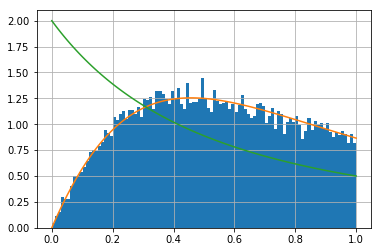

--- 80.43134379386902 seconds ---


In [6]:
import time
start_time = time.time()

nn_list = []
for i in range(10):
    H=SpinChain(14,.1).randomField()
    nn_list.append(Spectrum(H).ratios())

z = np.linspace(0., 1, 100)    
list_new=np.concatenate(nn_list)
plt.hist(list_new,100,normed=1)
plt.plot(z, r_wigner_vec(z))
plt.plot(z, r_poisson_vec(z))

plt.grid(True)
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))